# Binary classification (1 vs rest)

#### Импорт необходимых библиотек

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%ls

In [2]:

!pip install tensorflow-addons
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 35.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
%cd drive/MyDrive/YaMlProject/models/models/one_vs_all

/content/drive/MyDrive/YaMlProject/models/models/one_vs_all


In [4]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import sys

import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import torchvision as tv
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import seaborn
from sklearn.metrics import confusion_matrix
from livelossplot import PlotLossesKeras
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

sys.path.append('../../../')

from core.datasets import get_ds, open_f, DataSequence
from core.make_answer import make_ans_file

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
num_model = '_eight'

#### Формируем аугментацию.

In [7]:
transformer = tv.transforms.Compose([
    tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5),
    tv.transforms.RandomAffine(degrees=(-10, 10), translate=(0, 0.1), scale=(0.85, 1)),
    tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.7),
])

скачиваем файлы

In [8]:
batch_size = 100
data_all = open_f('repaired_data_train', 3)
data_test = open_f('repaired_data_test', 3)

меняем labels на 1/0 в зависимости от того, была ли изначально 1

In [9]:
print('До:', data_all['labels'])
data_all['labels'] = np.int0(data_all['labels'] == 8)
print('После:', data_all['labels'])

До: [1 3 2 ... 7 5 8]
После: [0 0 0 ... 0 0 1]


In [10]:
sm = SMOTE(random_state=42)
X_train, y_train = data_all['images'], data_all['labels']
X_train_copy = X_train.reshape(len(X_train), -1)
y_train_copy = y_train
X_train_sm, y_train_sm = sm.fit_resample(X_train_copy, y_train_copy)
X_train_sm = X_train_sm.reshape(-1, 32, 32, 3)
data_all['images'], data_all['labels'] = X_train_sm, y_train_sm

парсинг данных в 3 датасета

In [11]:
shuffle = np.random.permutation(data_all['labels'].shape[0])
train_images_full = data_all['images'][shuffle]
train_labels_full = data_all['labels'][shuffle]
train_ds_x, val_ds_x, train_ds_y, val_ds_y = train_test_split(train_images_full, train_labels_full,
                                                              test_size=0.12, random_state=1234)

val_ds = tf.data.Dataset.from_tensor_slices((val_ds_x / 255., val_ds_y))
val_ds = val_ds.batch(batch_size)
train_ds = DataSequence(train_ds_x, train_ds_y, transformer, batch_size=batch_size)

test_ds = data_test['images'] / 255.

Для дальнейшей проверки метрик разделяем валидационный датасет на x и y

In [12]:
val_ds_x = np.array([i[0] for i in val_ds.unbatch().as_numpy_iterator()])
val_ds_y = np.array([i[1] for i in val_ds.unbatch().as_numpy_iterator()])

Смотрим на получившуюся агументацию.

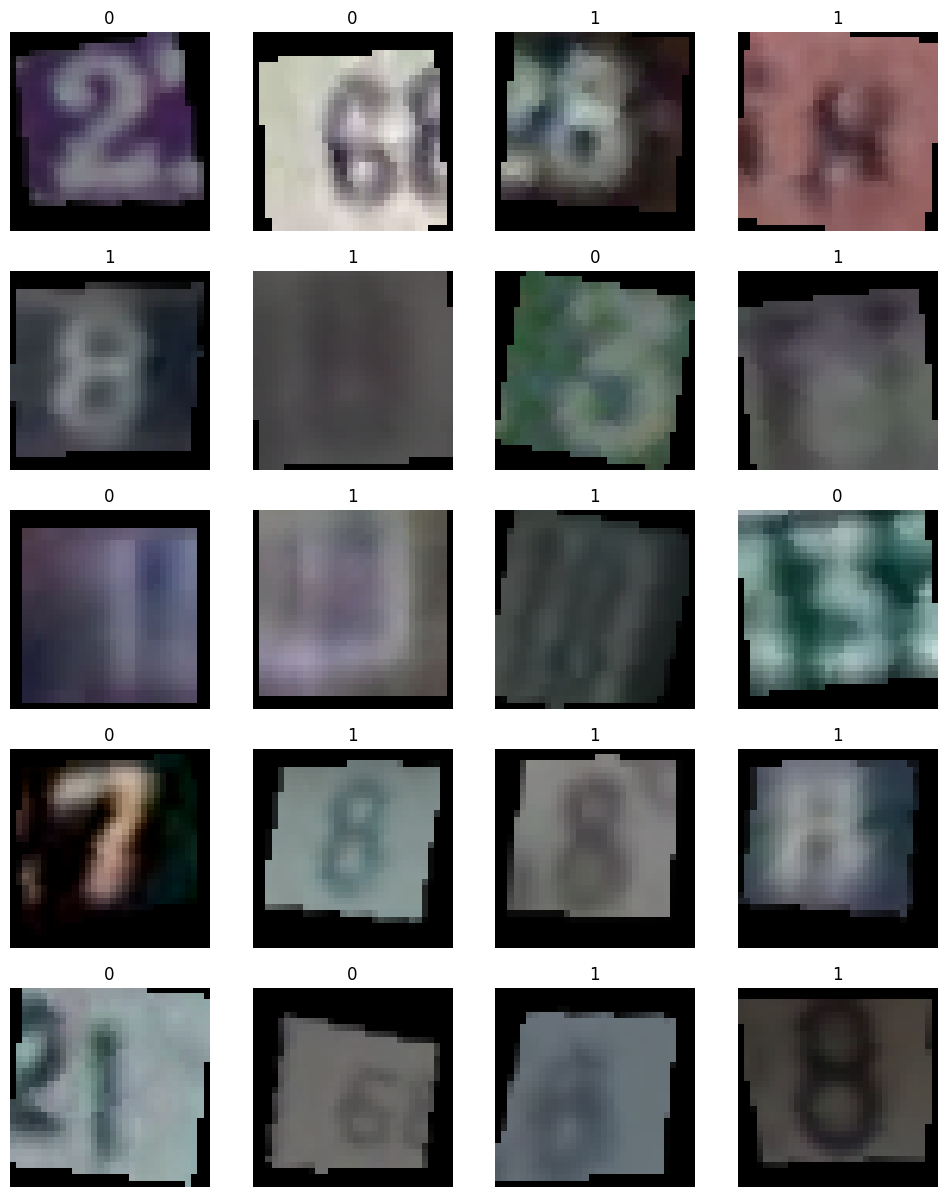

In [13]:
plt.figure(figsize=(12, 15))
train_ds_visualization = train_ds[0]
for i in range(20):
    plt.subplot(5, 4, i + 1)
    img = np.array(Image.fromarray((train_ds_visualization[0][i] * 255).astype(np.uint8), 'RGB'))
    plt.imshow(img / 255, cmap=plt.cm.binary)
    plt.title(train_ds_visualization[1][i])
    plt.axis('off')
plt.show()

#### Пишем модель

In [14]:
def tree(x, filters, kernel_size, strides=1, padding='same'):
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.keras.layers.ReLU()(x)

In [15]:
inputs = tf.keras.layers.Input(shape=(32, 32, 3))
x = tf.keras.layers.Conv2D(32, (5, 5), padding='same')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
fork = tf.keras.layers.ReLU()(x)

In [16]:
tree1 = tree(fork, 16, 1, strides=1)
tree2 = tree(fork, 16, 3, strides=1)
tree3 = tree(fork, 16, 5, strides=1)
tree4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(fork)
tree4 = tf.keras.layers.Conv2D(16, 1, padding='same', activation='relu')(tree4)

fork = tf.keras.layers.concatenate([tree1, tree2, tree3, tree4])
fork.shape

TensorShape([None, 32, 32, 64])

In [17]:
tree1 = tree(fork, 48, 3, 2, padding='valid')
tree2 = tf.keras.layers.MaxPooling2D(3, strides=2)(fork)
fork = tf.keras.layers.concatenate([tree1, tree2])
fork.shape

TensorShape([None, 15, 15, 112])

In [18]:
tree1 = tree(fork, 48, 1, strides=1)
tree2 = tree(fork, 48, 3, strides=1)
tree3 = tree(fork, 48, 5, strides=1)
tree4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(fork)
tree4 = tf.keras.layers.Conv2D(48, 1, padding='same', activation='relu')(tree4)

fork = tf.keras.layers.concatenate([tree1, tree2, tree3, tree4])

tree1 = tree(fork, 48, 1, strides=1)
tree2 = tree(fork, 48, 3, strides=1)
tree3 = tree(fork, 48, 5, strides=1)
tree4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(fork)
tree4 = tf.keras.layers.Conv2D(48, 1, padding='same', activation='relu')(tree4)

fork = tf.keras.layers.concatenate([tree1, tree2, tree3, tree4])
fork.shape

TensorShape([None, 15, 15, 192])

In [19]:

tree1 = tree(fork, 64, 3, 2, padding='valid')
tree2 = tf.keras.layers.MaxPooling2D(3, strides=2)(fork)
fork = tf.keras.layers.concatenate([tree1, tree2])
fork.shape

TensorShape([None, 7, 7, 256])

In [20]:
tree1 = tree(fork, 64, 1, strides=1)
tree2 = tree(fork, 64, 3, strides=1)
tree3 = tree(fork, 64, 5, strides=1)
tree4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(fork)
tree4 = tf.keras.layers.Conv2D(64, 1, padding='same', activation='relu')(tree4)

fork = tf.keras.layers.add([tree1, tree2, tree3, tree4])
fork.shape

TensorShape([None, 7, 7, 64])

In [21]:
x = tf.keras.layers.GlobalAveragePooling2D()(fork)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   2432        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 32, 32, 32)   0           ['batch_normalization[0][0]']

#### Создаем чекпоинты (всем уже рассказал)
- Если лень, то просто копипаст того, что я написал ниже. НЕ ЗАБЫВАЕМ МЕНЯТЬ ПЕРЕМЕННУЮ `num_model`!!!

In [22]:
metrics = ['accuracy']
callbacks = [
    PlotLossesKeras(),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../../checkpoints/model{num_model}_categorical_accuracy.h5',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../../checkpoints/model{num_model}_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),

    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../../checkpoints/model{num_model}_avg_categorical_accuracy.h5',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../../checkpoints/model{num_model}_avg_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    )
]

#### Компиляция модели
- Если будете что то менять, то только оптимизатор. Про оптимизаторы написано у Лизы.

In [23]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    return lr * tf.math.exp(-0.03)


callbacks.append(tf.keras.callbacks.LearningRateScheduler(scheduler))

In [24]:
model.compile(
    optimizer=tfa.optimizers.MovingAverage(tf.keras.optimizers.legacy.Adam(0.002)),
    metrics=metrics,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
)

#### Обучаем модель

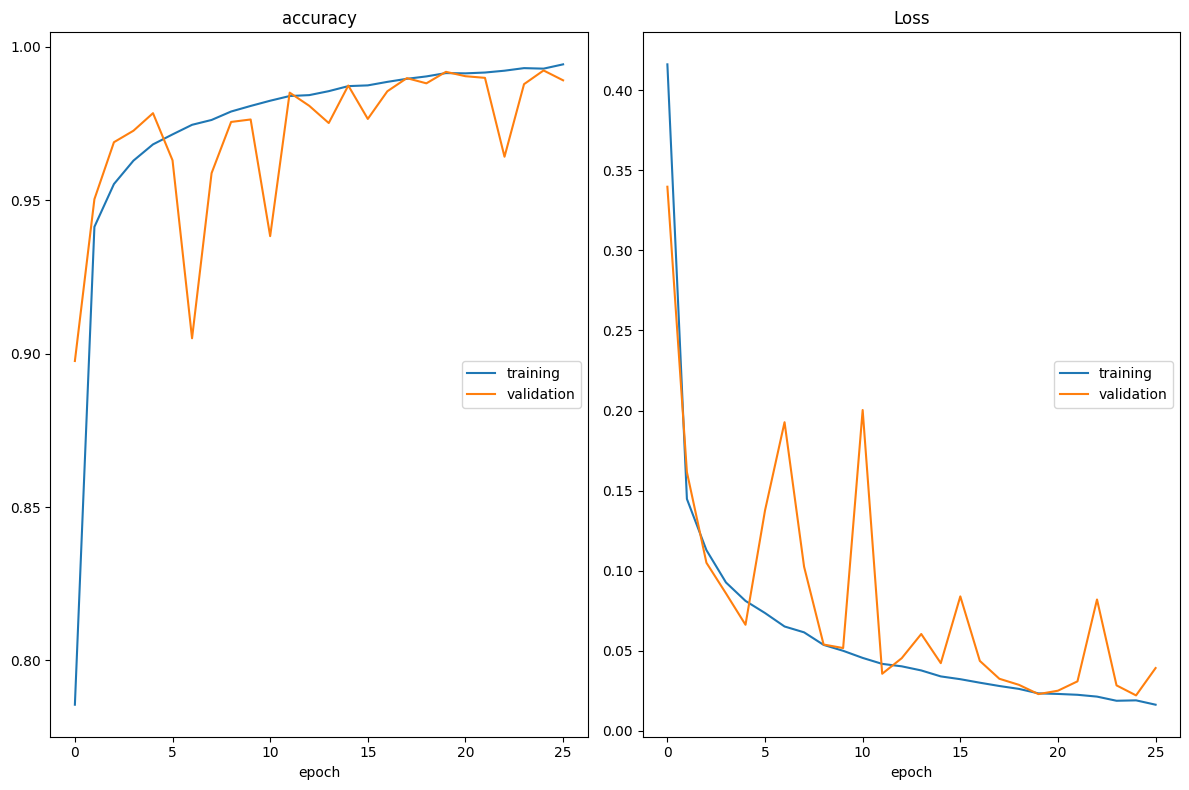

accuracy
	training         	 (min:    0.786, max:    0.994, cur:    0.994)
	validation       	 (min:    0.898, max:    0.992, cur:    0.989)
Loss
	training         	 (min:    0.016, max:    0.416, cur:    0.016)
	validation       	 (min:    0.022, max:    0.340, cur:    0.039)
822/822 [==============================] - 96s 116ms/step - loss: 0.0163 - accuracy: 0.9943 - val_loss: 0.0392 - val_accuracy: 0.9891 - lr: 0.0012
Epoch 27/100
239/822 [=======>......................] - ETA: 1:06 - loss: 0.0167 - accuracy: 0.9939

KeyboardInterrupt: ignored

In [25]:
model.fit(train_ds, validation_data=val_ds,
          epochs=100, callbacks=callbacks, verbose=1)

Подгружаем все чекпоинты

In [ ]:
model_categorical_acc = tf.keras.models.load_model(f'../checkpoints/model{num_model}_categorical_accuracy.h5')
model_f1_score = tf.keras.models.load_model(f'../checkpoints/model{num_model}_f1_score.h5')
model_loss = tf.keras.models.load_model(f'../checkpoints/model{num_model}_loss.h5')
model_avg_categorical_acc = tf.keras.models.load_model(f'../checkpoints/model{num_model}_avg_categorical_accuracy.h5')
model_avg_f1_score = tf.keras.models.load_model(f'../checkpoints/model{num_model}_avg_f1_score.h5')
model_avg_loss = tf.keras.models.load_model(f'../checkpoints/model{num_model}_avg_loss.h5')

У нас поличилось три чекпоинта (три модели). Ниже указан код для получения ответов для всех чекпоинтов по валидационному датасету.

In [ ]:
ans_val_categorical_accuracy = make_ans_file(model_categorical_acc, val_ds_x)
ans_val_f1_score = make_ans_file(model_f1_score, val_ds_x)
ans_val_loss = make_ans_file(model_loss, val_ds_x)
ans_val_avg_categorical_accuracy = make_ans_file(model_avg_categorical_acc, val_ds_x)
ans_val_avg_f1_score = make_ans_file(model_avg_f1_score, val_ds_x)
ans_val_avg_loss = make_ans_file(model_avg_loss, val_ds_x)
anss = [ans_val_categorical_accuracy, ans_val_f1_score, ans_val_loss, ans_val_avg_categorical_accuracy,
        ans_val_avg_f1_score, ans_val_avg_loss]

Формируем валидационные ответы.

In [ ]:
val_ds_y = np.argmax(val_ds_y, axis=1)

Сравниваем валидационные предикты каждого чекпоинта

In [ ]:
for i in range(len(anss) - 1):
    for j in range(i + 1, len(anss)):
        if np.all(anss[i] == anss[j]):
            print(f'чекпоинты {i + 1} и {j + 1} одинаковые')

`Все ответы разные, значит чекпоинты сохранили модель на разных эпохах. Если ответы будут одинковые, то вывод о чекпоинте делать не надо.`

- Денис пишет ансамблинг моделей. Когда он допишет, мы применим это для формирования ответа по трем получившимся моделям. То есть, если все чекпоинты разные, то мы будем делать средний ответ по трем предиктам.

В конце смотрим на метрики и делаем выводы о том, чем хороша эта модель. Какие классы она угадывает лучше/худше всего. Дописываем какую метрику показал kaggle.

In [ ]:
class MulticlassClassificationMetrics:
    def __init__(self, y_true, y_pred):
        self.y_true = np.array(y_true)
        self.y_pred = np.array(y_pred)
        self.matrix_error = self.get_matrix_error()

    def get_matrix_error(self):
        self.class_types = np.unique([self.y_true, self.y_pred])
        TP, FN, FP, TN = [], [], [], []
        for class_type in self.class_types:
            TP.append(np.sum(np.logical_and(self.y_true == self.y_pred, self.y_true == class_type)))
            FN.append(np.sum(np.logical_and(self.y_true == class_type, self.y_pred != class_type)))
            FP.append(np.sum(np.logical_and(self.y_pred == class_type, self.y_true != class_type)))
            TN.append(np.sum(np.logical_and(self.y_pred != class_type, self.y_true != class_type)))
        return pd.DataFrame({
            'class_type': self.class_types,
            'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        }).set_index('class_type')

    def accuracy(self):
        return np.sum(self.y_true == self.y_pred) / self.y_true.shape[0]

    def precision(self, averaging='macro'):
        if averaging == 'macro':
            precisions = self.matrix_error['TP'] / (self.matrix_error['TP'] + self.matrix_error['FP'])
            return np.mean(precisions.replace(np.nan, 0))
        elif averaging == 'micro':
            mean_val = self.matrix_error.mean()
            return mean_val['TP'] / (mean_val['TP'] + mean_val['FP'])

    def recall(self, averaging='macro'):
        if averaging == 'macro':
            recalls = self.matrix_error['TP'] / (self.matrix_error['TP'] + self.matrix_error['FN'])
            return np.mean(recalls.replace(np.nan, 0))
        elif averaging == 'micro':
            mean_val = self.matrix_error.mean()
            return mean_val['TP'] / (mean_val['TP'] + mean_val['FN'])

    def f1_score(self, averaging='macro'):
        if averaging == 'macro':
            reverse_r = (self.matrix_error['TP'] + self.matrix_error['FN']) / self.matrix_error['TP']
            reverse_p = (self.matrix_error['TP'] + self.matrix_error['FP']) / self.matrix_error['TP']
            f1_scores = 2 / (reverse_r + reverse_p)
            return np.mean(f1_scores.replace(np.nan, 0))
        elif averaging == 'micro':
            p = self.precision(averaging)
            r = self.recall(averaging)
            return 2 * p * r / (p + r)

    def metrics(self, averaging='macro'):
        return {
            'accuracy': self.accuracy(),
            'precision': self.precision(averaging),
            'recall': self.recall(averaging),
            'f1_score': self.f1_score(averaging),
        }

    def __str__(self):
        headers = {
            'selector': '*',
            'props': 'background-color: darkgreen; color: white; font-size: 12pt;',
        }
        che_super_mega_puper_visualization_of_cell = {
            'selector': 'td:hover',
            'props': 'background-color: green; color: white;',
        }
        display(
            self.matrix_error
            .style
            .set_table_styles([
                headers,
                che_super_mega_puper_visualization_of_cell,
            ])
            .set_properties(**{'background-color': 'lightgreen',
                               'color': 'black', 'font-size': '12pt'})
        )
        return ''

    def __repr__(self):
        return (
            f'MulticlassClassificationMetrics(class_types={self.class_types})'
            .replace("'", '').replace(',', ';'))

/usr/local/lib/python3.9/dist-packages/matplotlib/cbook/__init__.py:1399: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xi = np.asanyarray(xi)


ValueError: ignored

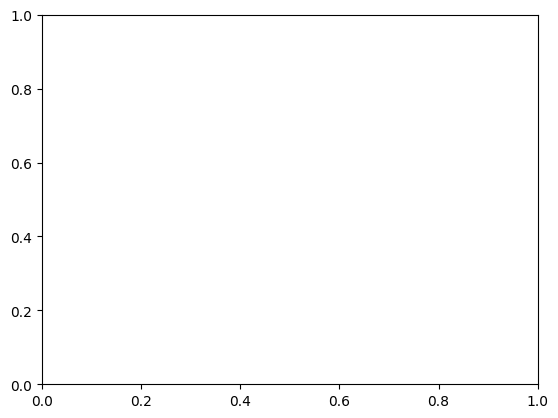

In [ ]:
plt.hist(val_ds)

### Accuracy чекпоинт

In [ ]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_categorical_accuracy)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,637,6091,23,5
1,622,6068,19,47
2,679,6046,13,18
3,619,6098,21,18
4,679,6044,21,12
5,665,6053,24,14
6,662,6061,21,12
7,683,6053,5,15
8,690,6035,15,16


{'accuracy': 0.9745411486086442,
 'precision': 0.9744590299195288,
 'recall': 0.9745309164139805,
 'f1_score': 0.9744109029056552}

- $FP_1=15$. То есть, модель предсказала 15 раз 1, когда на самом деле там была не 1. Наверное модель плохо различает 1 и 7.
- $FN_1=15$. То есть, модель 15 раз ошиблась, когда угадывала 1.

Метрики более менее хоршие. Переобучения нет. Ставить модель на больше эпох нет смысла, потому что последние 50 эпох модель практически не меняла веса.

`Это не шаблон!!! Писать надо как сами посчитаете`

### Loss чекпоинт

In [ ]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_loss)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,634,6096,18,8
1,637,6046,41,32
2,675,6049,10,22
3,615,6099,20,22
4,670,6052,13,21
5,663,6048,29,16
6,653,6073,9,21
7,687,6048,10,11
8,694,6030,20,12


{'accuracy': 0.9736530491415039,
 'precision': 0.973677324143152,
 'recall': 0.9736129222642212,
 'f1_score': 0.9736029903397279}

- $FN_1=28$.
- $FP_1=19$.
- $FP_2=18$.
- $FP_3=18$.
- $FN_3=16$.
- $FN_8=15$.

Модель очень плохо справляется с единицами. Так же можно сказать что 2 и 3 модель часто угадывает ложно.

Метрики хуже, чем у accuracy чекпоинта. Но все равно посмотрим, что скажут метрики kaggle.

### F1-score чекпоинт

In [ ]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_f1_score)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,631,6100,14,11
1,641,6056,31,28
2,676,6044,15,21
3,617,6102,17,20
4,676,6051,14,15
5,661,6059,18,18
6,659,6060,22,15
7,684,6044,14,14
8,685,6033,17,21


{'accuracy': 0.9745411486086442,
 'precision': 0.9745203138161944,
 'recall': 0.974563678629346,
 'f1_score': 0.9745351352374214}

- $FN_1=19$.
- $FP_2=19$.

Модель плохо справляется с единицами и двойками.

Метрики неплохие.

### Среднее скользящее по accuracy чекпоинт

In [ ]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_avg_categorical_accuracy)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,635,6100,14,7
1,633,6064,23,36
2,679,6048,11,18
3,616,6106,13,21
4,675,6048,17,16
5,667,6059,18,12
6,662,6064,18,12
7,690,6046,12,8
8,692,6034,16,14


{'accuracy': 0.9772054470100652,
 'precision': 0.9771705185745387,
 'recall': 0.9771486563327392,
 'f1_score': 0.9771360296324516}

### Скользящее среднее по F1-score чекпоинт

In [ ]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_avg_f1_score)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,635,6096,18,7
1,633,6063,24,36
2,680,6045,14,17
3,617,6108,11,20
4,680,6051,14,11
5,664,6059,18,15
6,658,6067,15,16
7,690,6047,11,8
8,692,6034,16,14


{'accuracy': 0.9776494967436353,
 'precision': 0.9776056513292668,
 'recall': 0.9775898938910853,
 'f1_score': 0.9775753424397144}

### Скользящее среднее по Loss чекпоинт

In [ ]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_avg_loss)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,690,6042,14,10
1,635,6069,24,28
2,668,6045,22,21
3,688,6024,21,23
4,645,6082,16,13
5,588,6133,10,25
6,679,6049,13,15
7,692,6043,12,9
8,631,6096,17,12


{'accuracy': 0.9748371817643576,
 'precision': 0.974880653549054,
 'recall': 0.9746531385254105,
 'f1_score': 0.9747449230461165}

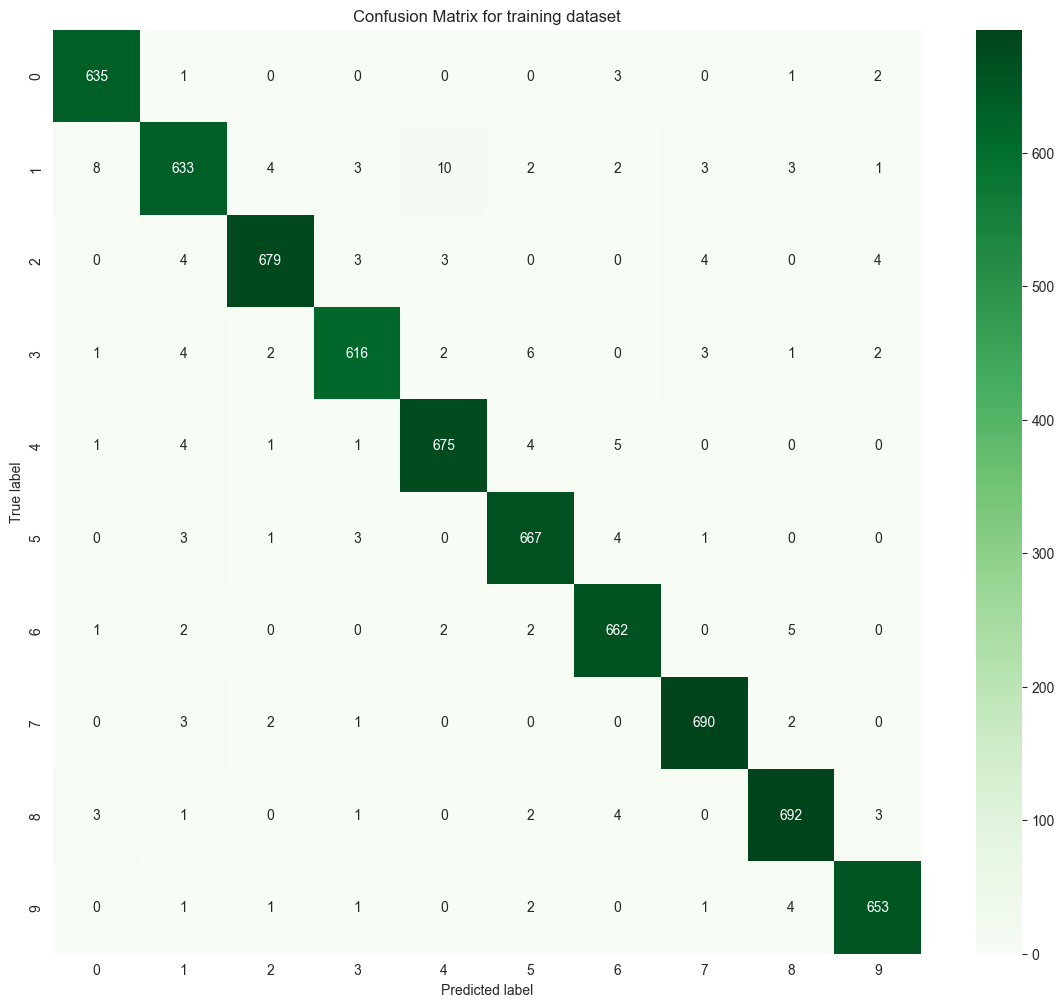

In [ ]:
matrix = confusion_matrix(val_ds_y, ans_val_avg_categorical_accuracy)

fig, ax = plt.subplots(figsize=(14, 12))
seaborn.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
plt.title('Confusion Matrix for training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

- Сохраняем ответы.

In [ ]:
ans_test_categorical_accuracy = make_ans_file(model_categorical_acc, test_ds,
                                              f'../answers/model{num_model}_categorical_accuracy.csv')
ans_test_f1_score = make_ans_file(model_f1_score, test_ds, f'../answers/model{num_model}_f1_score.csv')
ans_test_loss = make_ans_file(model_loss, test_ds, f'../answers/model{num_model}_loss.csv')
ans_test_avg_categorical_accuracy = make_ans_file(model_avg_categorical_acc, test_ds,
                                                  f'../answers/model{num_model}_avg_categorical_accuracy.csv')
ans_test_avg_f1_score = make_ans_file(model_avg_f1_score, test_ds, f'../answers/model{num_model}_avg_f1_score.csv')
ans_test_avg_loss = make_ans_file(model_avg_loss, test_ds, f'../answers/model{num_model}_avg_loss.csv')

Проверяем ответы (одинаковые они или нет), чтоб не терять кол-во отправок ответов на kaggle в день.

In [ ]:
for i in range(len(anss) - 1):
    for j in range(i + 1, len(anss)):
        if np.all(anss[i] == anss[j]):
            print(f'чекпоинты {i + 1} и {j + 1} одинаковые')

Все ответы разные, поэтому отправляем все на kaggle

- Accuracy чекпоинт: 0.93493
- Loss чекпоинт: 0.92866